In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_breast_cancer()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [2]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 
# Select only the desired features
data_X = X[['mean radius', 'mean concave points']].to_numpy()

# Encode y to be +1 and -1
le = LabelEncoder()
data_y = le.fit_transform(y)
data_y[data_y == 0] = -1  # Replace 0 with -1

[Text(0.5, 0, 'mean radius'), Text(0, 0.5, 'mean concave points')]

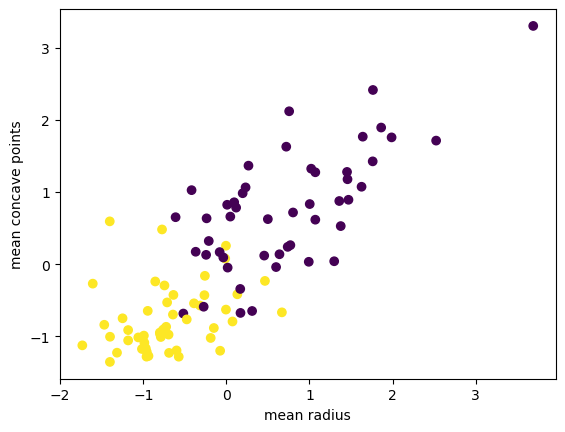

In [3]:
n = 100
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='mean radius', ylabel='mean concave points')

In [4]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    plt.legend()
    #plt.title('Soft Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['CVX Solution', 'ODE Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()
    
def plot_svm_decision_boundary_confrontation_PINN(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Malignant')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Benign')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['ODE Solution', 'PINN Solution', 'Malignant', 'Benign']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'mean radius')
    plt.ylabel(f'mean concave points')
    #plt.title('SVM Decision Boundaries')
    plt.show()

In [5]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b']
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

In [6]:
def hyperplane_similarity(w, b, w_opt, b_opt, alpha=0.5, beta=0.5):
    """
    Computes a metric to measure the similarity between two hyperplanes defined by (w, b) and (w_opt, b_opt).
    
    Parameters:
    - w (np.ndarray): Normal vector of the first hyperplane.
    - b (float): Offset of the first hyperplane.
    - w_opt (np.ndarray): Normal vector of the optimal hyperplane.
    - b_opt (float): Offset of the optimal hyperplane.
    - alpha (float): Weight for the angular difference metric. Default is 0.5.
    - beta (float): Weight for the offset difference metric. Default is 0.5.
    
    Returns:
    - float: Combined metric value. Closer to 0 indicates more similar hyperplanes.
    """
    # Normalize vectors for angle computation
    norm_w = np.linalg.norm(w)
    norm_w_opt = np.linalg.norm(w_opt)
    
    # Handle edge cases for zero vectors
    if norm_w == 0 or norm_w_opt == 0:
        raise ValueError("The normal vector of a hyperplane cannot be a zero vector.")
    
    # Compute cosine similarity and angle metric
    cos_theta = np.dot(w, w_opt) / (norm_w * norm_w_opt)
    angle_metric = 1 - cos_theta
    
    # Normalize vectors to unit length for offset comparison
    w_unit = w / norm_w
    w_opt_unit = w_opt / norm_w_opt
    
    # Compute the offset difference metric
    offset_diff = abs(b / norm_w - b_opt / norm_w_opt)
    offset_metric = offset_diff / max(abs(b / norm_w), abs(b_opt / norm_w_opt), 1)
    
    # Combine metrics
    combined_metric = alpha * angle_metric + beta * offset_metric
    return combined_metric

# CVX

Time: 0.01944756507873535
Optimal objective value: 221.92285598307484
SCS solver iterations: 925
SCS solve time: 0.006233238
SCS setup time: 0.0019238340000000001
Optimal w:  [-1.68366411 -2.03955988]
Optimal b:  [-0.69861657]
Dual variables (Lagrange multipliers): [ 0.          0.          0.          0.          0.          0.
 10.00000008  0.          0.         -0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.         10.00000014  0.          0.          0.          0.
  0.          0.          0.         -0.         10.00000035  0.
  0.          0.          0.          0.         -0.         10.0000003
  0.          0.          0.          0.          2.71004509 10.0000002
  0.          0.          0.          0.          0.          0.
  0.          0.         10.00000019 10.00000026 10.00000031  0.
  0.          0.         10.00000039  0.         10.00000012  4.37156662
  0.          9.99999975  0.          0.          0.          

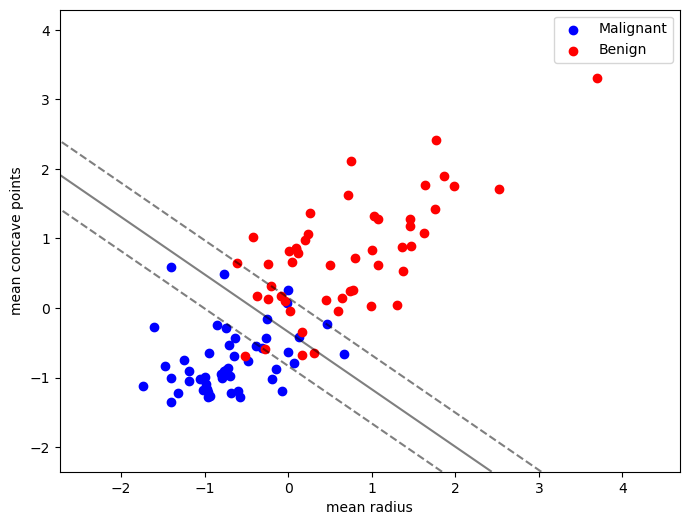

In [7]:
import cvxpy as cp
import numpy as np
import time

C = 10

num_features = selected_X.shape[1]

w = cp.Variable(num_features)
b = cp.Variable(1)
xi = cp.Variable(selected_y.shape[0])

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2 + C * cp.sum(xi))

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1 - xi,
    xi >= 0
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g_1 = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_2 = [np.array([-xi.value[i]]) for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g_1 + g_2).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

wb_cvx = np.concatenate([w.value, b.value])

# ODE

In [8]:
nw = selected_X.shape[1]
nb = 1
nxi = selected_y.shape[0]
nx = nw + nb + nxi
nu = selected_X.shape[0] * 2
NY = nx+nu

def f(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    output = (1/2) * jnp.linalg.norm(w, 2)**2 + C * jnp.sum(xi)
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    xi = x[nw+nb:]
    
    g_1 = [-selected_y[i] * (w @ selected_X[i] + b) + 1 - xi[i] for i in range(selected_y.shape[0])]
    g_2 = [- xi[i] for i in range(selected_y.shape[0])]
    output = jnp.array(g_1 + g_2)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)


In [9]:

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def evaluation_plus(xu):
    x, u= xu[:nx], xu[nx:]
    lim = None
    if (g(x)<=0.001).all():
        lim = 0.001
    elif (g(x)<=0.01).all():
        lim = 0.01
    elif (g(x)<=0.1).all():
        lim = 0.1
    elif (g(x)<=1).all():
        lim = 1
    return f(x), lim


In [10]:
def solve_ODE(xuv0, T):
    t0 = time.time()
    sol = solve_ivp(ODE, [0., T], xuv0, method=NUMERICAL_METHOD)
    solve_time = time.time() - t0
    print('Time:', solve_time)
    result = P(sol.y[:, -1])
    
    obj, lim = evaluation_plus(result)
    print("objective:", obj, "lim:", lim)
    
    print("objective:", obj)
    print("w: ", result[:nw], "b: ", result[nw])
    wb_ode = result[:nw+nb]
    similarity = hyperplane_similarity(result[:nw], result[nw], wb_cvx[:nw], wb_cvx[nw])
    print("hyperplane similarity:", similarity)
    print("Dual variables (alpha):", result[:nx])
    print("Constraints:",g(result[:nx]))
    
    return sol, result, obj, lim, similarity

# PINN

In [11]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i >= 1000 and all(x < 0.01 for x in L_loss[-5:]):
                break
            
            if i==ITERATIONS:
                break

        curr_net = deepcopy(net)
        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, curr_net, L_loss, time.time()-t0, i

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*(t / T).detach().reshape((-1, )))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        return dynamics_loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]

# Runs

In [12]:
def iteration(ip):
    xu0 = jnp.array(ip)
    y0 = ip
    
    # ODE Solution
    sol, result, obj, lim, similarity = solve_ODE(xu0, T)
    
    if lim == None:
        print('>>> Infeasible')
    else:
        print('>>> Feasible with epsilon:', lim, 'objective:', obj)

    print("hyperplane similarity:", similarity)
    if similarity < 0.01:
        print('>>> ODE Solution is accurate, last iteration')
        lastIter = True
    else:
        lastIter = False
        
    t_values = sol.t
    y_values = sol.y

    w_ode = result[:data_X.shape[1]]
    b_ode = result[data_X.shape[1]]

    plot_ode_system(t_values, y_values)

    plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)
    
    example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
    L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, net_curr, L_loss, t, n_iter = example.NN_method() # train
    print('epsilon:', L_epsilon[-1], 'time:', t, 'iterations:', n_iter)
    
    # ------------ NN plots ------------ 
    plt.plot(L_epsilon, marker='o', linestyle='-', label='OuC metric best', markersize=1)
    plt.plot(L_epsilon_curr, marker='o', linestyle='-', label='OuC metric current', markersize=1)
    plt.xlabel('iteration')
    plt.ylabel('OuC metric')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)

    plt.tight_layout()
    # Show the plot
    plt.show()
    
    print('Last losses:', L_loss[-10:])

    plt.plot(L_loss, label='Loss')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    #plt.title(f'l={res_1["layers"]}, n={res_1["neurons"]}, lr={res_1["lr"]}')
    plt.legend()
    plt.grid(False)
    #plt.set_ylim(y_min, y_max)
    plt.xlim(0, ITERATIONS)
    plt.tight_layout()
    # Show the plot
    plt.show()
    
    if n_iter != ITERATIONS and lastIter:
        print('>>> NN Solution is accurate, last iteration')
        net = net_curr
        lastIter = True
    else:
        lastIter = False
        net = net_curr
    
    res = net(torch.tensor([T]).cuda()).cpu().detach().numpy()
    plot_svm_decision_boundary_confrontation_PINN(selected_X, selected_y, w_ode, b_ode, res[:data_X.shape[1]], res[data_X.shape[1]], 0, 1)
    print('Variables:', res[:nx])
    print('Constraints:', g(res[:nx]))
    
    pinn_obj, lim_pin = evaluation_plus(res)
    
    print("objective pinn:", pinn_obj, "epsion pinn:", lim_pin)
    
    print("w: ", res[:nw], "b: ", res[nw])

    similarity_pinn = hyperplane_similarity(res[:nw], res[nw], wb_cvx[:nw], wb_cvx[nw])
    print("PINN hyperplane similarity:", similarity_pinn)
    
    return res, pinn_obj, lastIter

In [13]:
NBATCH = 512
WEIGTHING = 1
LAYERS = 2
NEURONS = 100
LR = 0.001
T = 20.0

>>>> ITERATION: 1


Time: 15.030343532562256


objective: 178.04184 lim: 1
objective: 178.04184
w:  [-1.4697371  -1.70081869] b:  -0.5058124136370293
hyperplane similarity: 0.019695432751877906
Dual variables (alpha): [-1.4697371  -1.70081869 -0.50581241  0.00715434  0.00049364  0.00049363
  0.00049315  0.00049356  0.00049373  0.21850458  0.00036695  0.00049358
  0.00656678  0.00049251  0.00049384  0.00049365  0.00049368  0.00049351
  0.00049375  0.00049356  0.00049369  0.00049376  0.51527511  0.00614561
  0.00048183  0.00049378  0.00049378  0.00049349  0.00049353 -0.07858196
  0.00049356  1.08924457  0.00049324 -0.08294236  0.00048817  0.000485
  0.00049377  0.00049344  0.13734684 -0.19332488  0.00049359  0.00049359
  0.0004937   0.03480732  1.8166512  -0.04393524  0.00044143  0.00049371
  0.00010928 -0.11006823 -0.1054961   0.00049361  0.00049128  0.42634609
  1.61862696  1.93074073  0.00049369  0.00049323 -0.11563006  0.21582462
  0.00047785  0.19520739  0.14766822  0.00049356  0.3733897   0.00049365
  0.00006332  0.00049365  1.

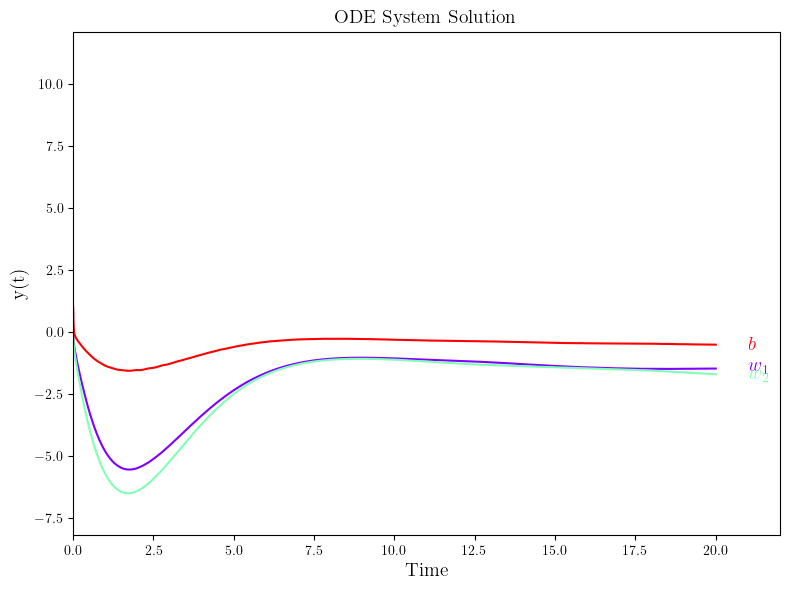

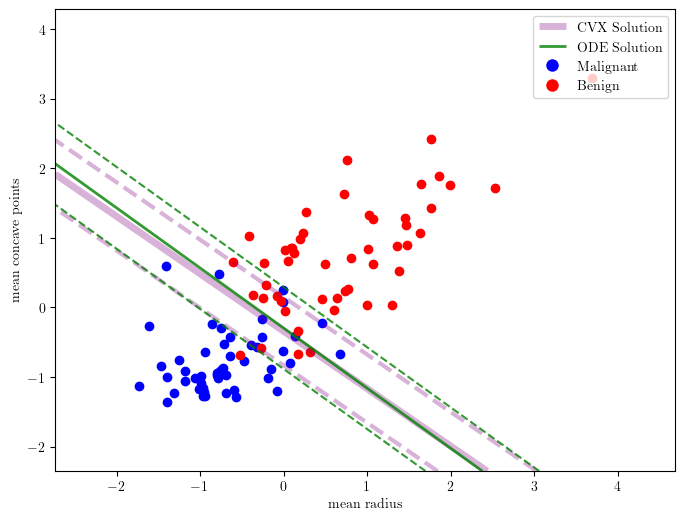

epsilon: 917.3035 time: 1425.9121317863464 iterations: 2000


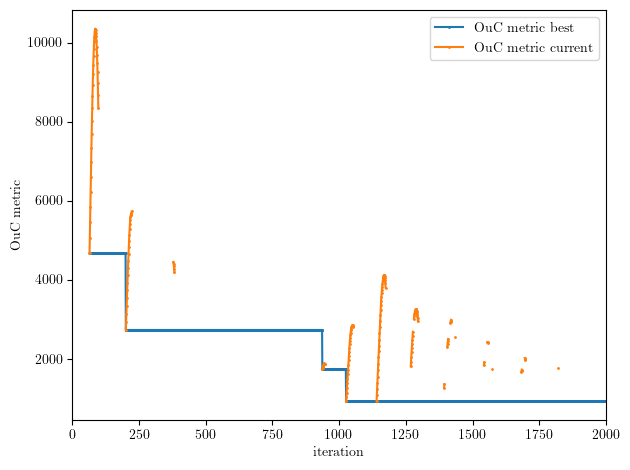

Last losses: [321.40667724609375, 188.81590270996094, 144.36892700195312, 110.70735168457031, 108.34163665771484, 233.42355346679688, 307.39666748046875, 431.6580810546875, 392.15972900390625, 450.88555908203125]


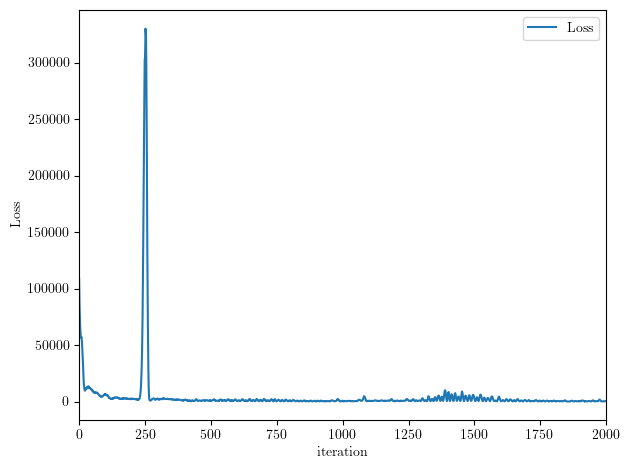

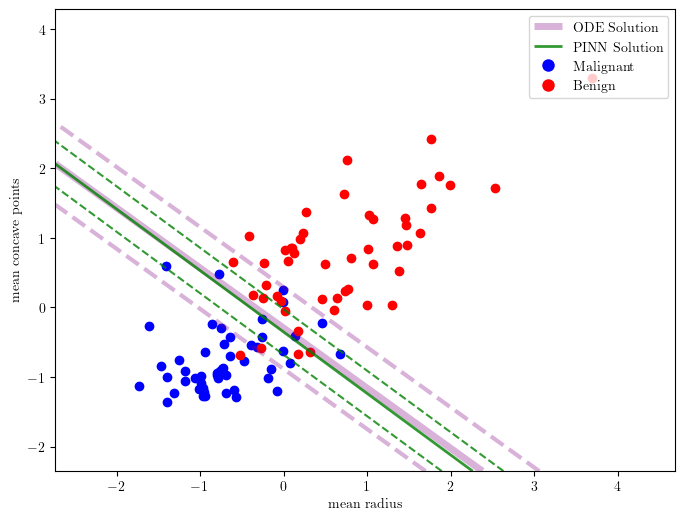

Variables: [-2.7070024  -3.0623465  -1.0830617  -1.7882003  -1.8362405  -1.6364223
 -1.5137143  -1.6789972  -1.652795   -1.2886014  -1.6083584  -1.1554456
 -1.5272677  -1.2842457  -1.8126963  -1.5999867  -1.670292   -1.6378956
 -1.87536    -1.5664779  -1.5072002  -1.8957852  -1.0438241  -1.5956353
 -1.5543749  -1.7079098  -1.7162431  -1.4980423  -1.4873352  -1.5487242
 -1.5451791  -0.7943145  -1.0074565  -1.5154012  -1.3706137  -1.494716
 -1.9272078  -1.5670154  -1.4161081  -1.317065   -1.2468128  -1.8153435
 -1.7510026  -1.4871266   0.09863888 -1.5298197  -1.5482805  -1.6995401
 -1.775201   -1.256801   -1.6798089  -1.5952377  -1.4746586  -1.0537144
 -0.33241063  0.4790225  -1.6540873  -1.5780253  -1.3073791  -1.1334347
 -1.3727337  -1.3237549  -0.9337455  -1.5454772  -0.7526282  -1.5387322
 -1.7842016  -1.590809   -0.27217323 -1.6661798  -0.75261825 -1.4753209
 -1.9205223   0.93410605 -1.8448173  -0.82591945 -1.5187168  -0.90636086
 -1.2519644  -1.630976   -1.6623552  -1.576432   -1.6

Time: 3.2804417610168457
objective: 191.91806 lim: 1
objective: 191.91806
w:  [-1.44304392 -1.83214725] b:  -0.5402598729329234
hyperplane similarity: 0.01638300103411751
Dual variables (alpha): [-1.44304392 -1.83214725 -0.54025987 -0.00017245  0.00008534  0.00007924
  0.00008797  0.00007659  0.00007665  0.18923032  0.00009726  0.00007745
 -0.00915659  0.00004522  0.00007989  0.00007612  0.00008011  0.00007603
  0.0000726   0.00008335  0.00008459  0.00007631  0.9913327  -0.00011959
  0.00008246  0.00008251  0.00008068  0.00007955  0.00008196 -0.08095931
  0.00007802  1.32729659  0.00006147 -0.06717298  0.00006195  0.00007727
  0.00006098  0.0000822   0.09409281 -0.21274539  0.00004472  0.0000799
  0.00008108  0.01544633  1.79550433  0.00576438  0.00009352  0.0000764
  0.0083532   0.00390648 -0.15157659  0.00008342  0.00006419  0.55908617
  1.678516    2.02208734  0.00007816  0.00008396 -0.18688766  0.30493529
  0.00007962  0.18583585  0.06847216  0.00007663  0.4569083   0.0000781
  0.0

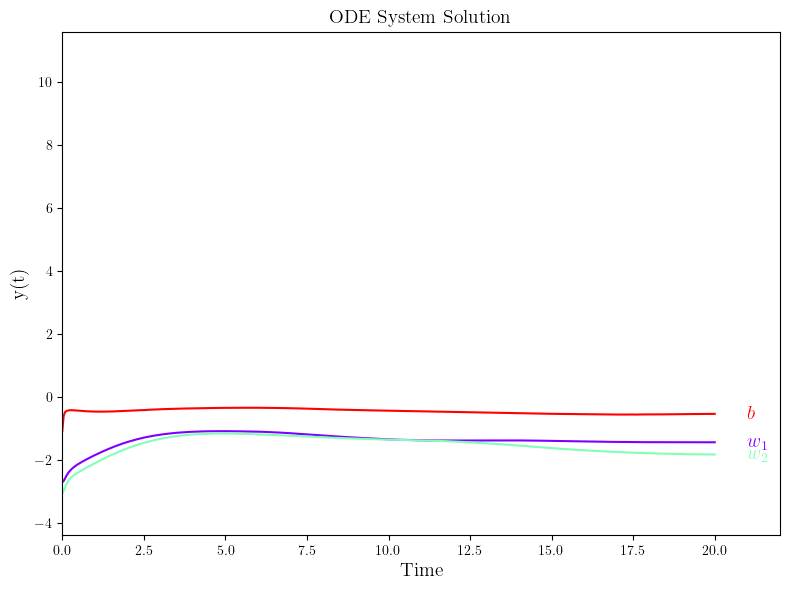

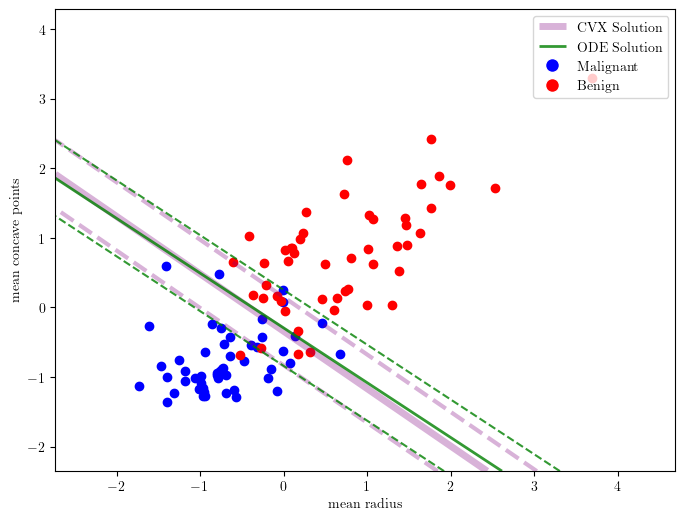

epsilon: inf time: 7060.150412321091 iterations: 10000


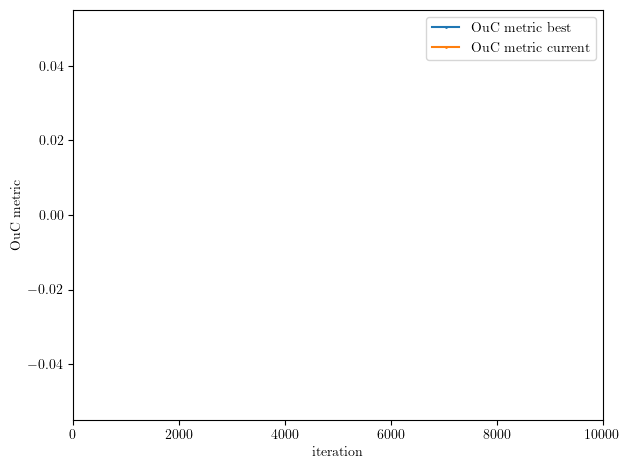

Last losses: [3.095836877822876, 3.096353530883789, 3.8889827728271484, 3.293513298034668, 4.481719970703125, 3.388219118118286, 3.575751304626465, 3.896726369857788, 3.3590855598449707, 4.278862953186035]


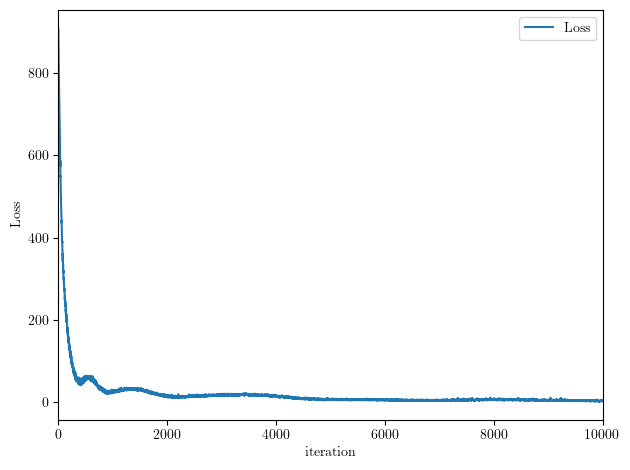

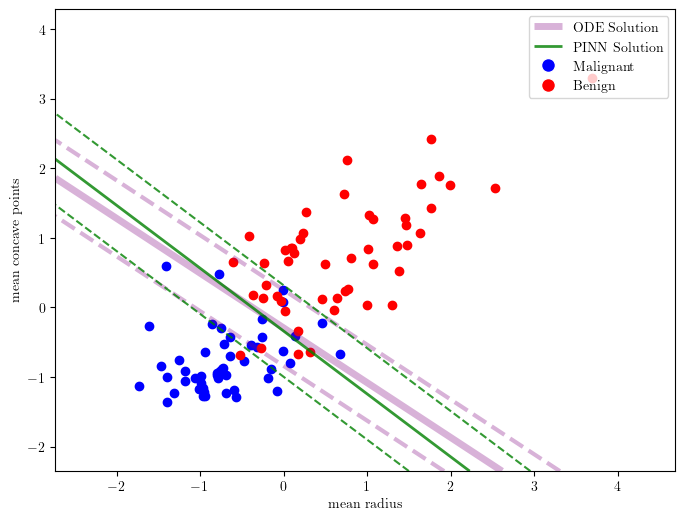

Variables: [-1.3750325  -1.5208427  -0.51726836  0.03061867 -0.04477942 -0.03179479
 -0.04511714 -0.03309238 -0.00566685  0.2062856  -0.1065073  -0.01326334
  0.03709459 -0.0190382  -0.01444101 -0.01534784 -0.03169394 -0.04744709
 -0.02434897 -0.0197202  -0.0278461  -0.01159561  0.4177631   0.04884756
 -0.02437735 -0.02525282 -0.01701272 -0.01717794 -0.02762008 -0.03587008
 -0.04220247  0.8616899  -0.01279926 -0.03329134 -0.04271495 -0.01981366
 -0.03360832 -0.02927852  0.15350938 -0.13685775 -0.01747882 -0.04277921
 -0.03788972  0.07706964  1.7314308  -0.12533987 -0.03861105 -0.02922237
 -0.17998624 -0.13002348 -0.03832793 -0.0334326  -0.00109196  0.29702377
  1.7123835   1.7383846  -0.02763879 -0.04531991 -0.08941972  0.17996573
 -0.02908397  0.18965054  0.19011605 -0.02343488  0.34704757 -0.01124835
 -0.20635915 -0.01039827  1.496964   -0.02547598  0.3553303  -0.06591618
 -0.03386617  1.7844648  -0.02714372  0.23299998  0.00076687  0.17089653
 -0.13012922 -0.03523517 -0.01455164 -0.

Time: 1.590477466583252
objective: 205.71378 lim: 1
objective: 205.71378
w:  [-1.66352712 -1.84289216] b:  -0.6081953735316649
hyperplane similarity: 0.01007692626083491
Dual variables (alpha): [-1.66352712 -1.84289216 -0.60819537 -0.00000119 -0.00000007 -0.00000112
  0.00000059 -0.00000036 -0.00000062  0.22319791  0.00000351 -0.00000086
 -0.01763043 -0.00000148 -0.00000028 -0.00000024  0.00000109 -0.00000003
 -0.00000137 -0.00000014  0.00000019 -0.00000146  1.06885226 -0.0000009
  0.00000005  0.00000015 -0.00000019 -0.00000058  0.00000019 -0.11693967
  0.00000034  1.20574378 -0.00000033 -0.127668    0.00000047 -0.00000008
 -0.00000241  0.00000014  0.13717095 -0.00017063 -0.00000127 -0.0000009
 -0.0000007   0.01505164  1.96513672  0.0000018  -0.00000027 -0.00000055
 -0.00000234  0.00000259 -0.0854929   0.00000075 -0.00000143  0.88651184
  1.73601407  2.07745738  0.00000013  0.00000051 -0.19046971  0.18195434
  0.00000016  0.19077517  0.10472031 -0.00000199  0.68510357 -0.00000059
 -0.0

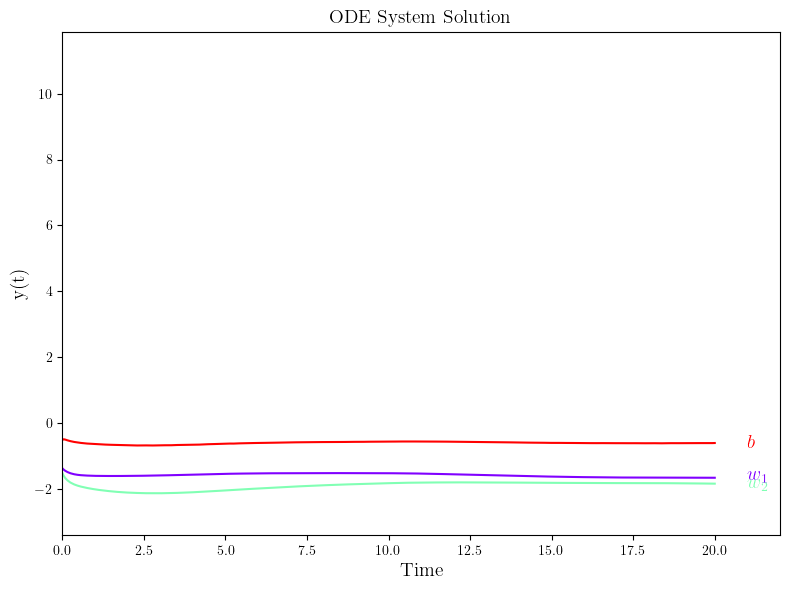

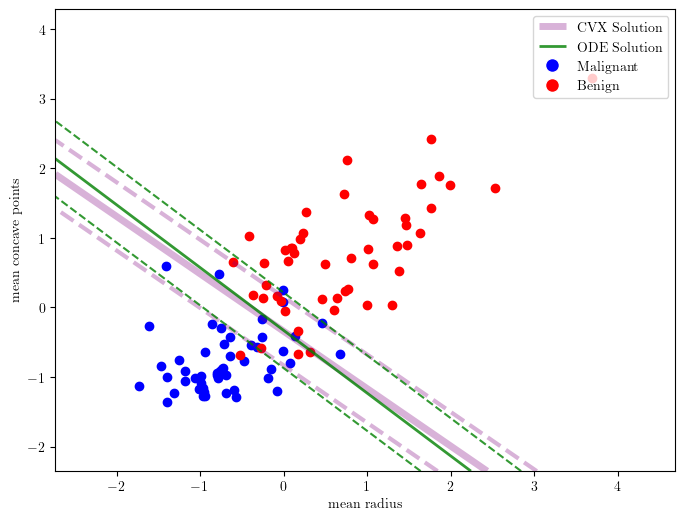

epsilon: inf time: 7026.95282793045 iterations: 10000


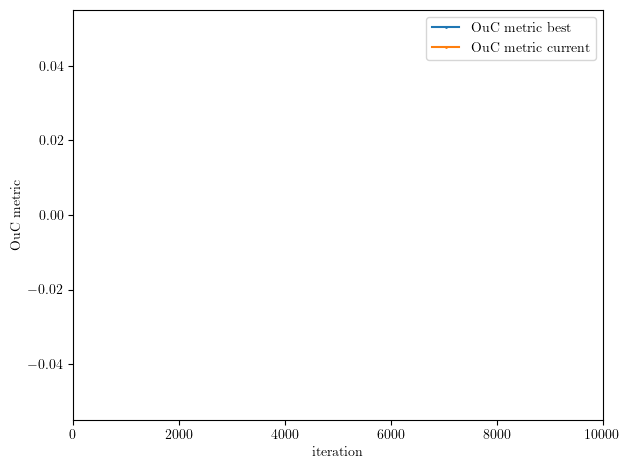

Last losses: [0.35415688157081604, 0.23004421591758728, 0.17657673358917236, 0.15379421412944794, 0.17043885588645935, 0.21625521779060364, 0.3887917399406433, 0.4820985198020935, 0.6834264397621155, 0.876104474067688]


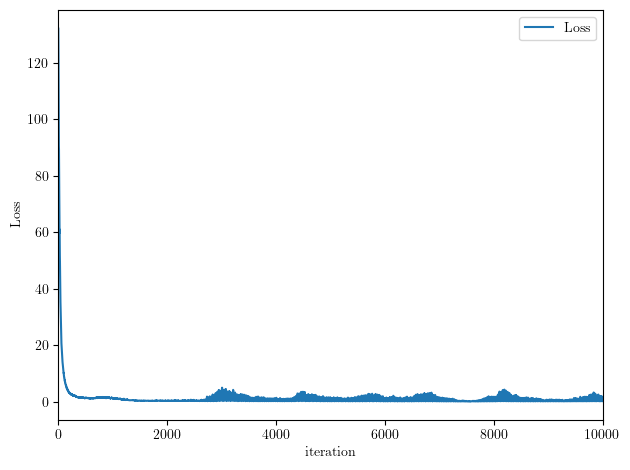

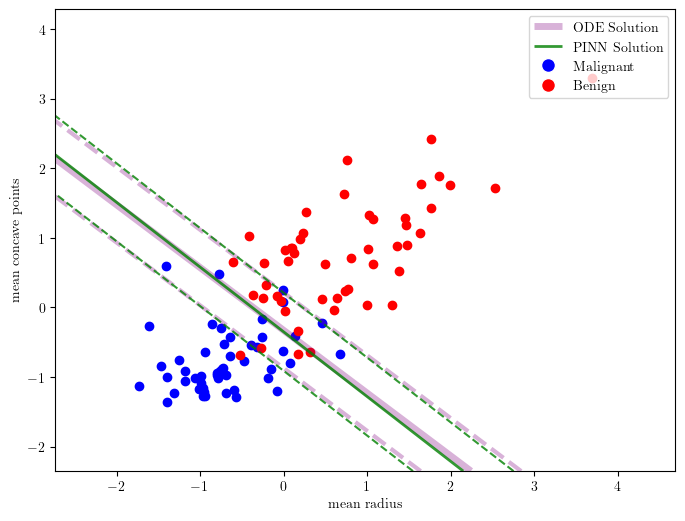

Variables: [-1.6614274  -1.7844806  -0.6270261  -0.00243462 -0.00692861  0.00927661
 -0.00633014  0.00053546 -0.00028902  0.21067926 -0.00732398 -0.01313712
 -0.03866984 -0.02100727 -0.00796831  0.00787318 -0.00771782 -0.01240814
  0.00124791 -0.01473453  0.00830958 -0.0155724   1.0798843   0.00787119
 -0.00381794  0.00371658 -0.00116565  0.00191116  0.0110539  -0.14178754
  0.00173253  1.2201746   0.00338294 -0.155509    0.012731    0.0179867
  0.00218135 -0.00819688  0.1176347  -0.02711042  0.0060357   0.00757579
 -0.00211199 -0.00761317  1.9774611   0.00047925  0.00012852 -0.00396803
  0.01120952  0.00062785 -0.13115779  0.03187688  0.00303658  0.81445086
  1.7397983   2.0743039  -0.00101461 -0.00371343 -0.14178011  0.12061987
 -0.01551308  0.15254717  0.15298317  0.00565887  0.6859771   0.00087607
  0.01687384  0.01382389  1.3293223  -0.00642885  0.7238198  -0.00171123
 -0.00898124  1.9365326   0.00179442  0.17160699 -0.11748111  0.11419102
  0.10418873 -0.00953544 -0.01090392  0.0

Time: 2.282466173171997
objective: 216.3838 lim: 1
objective: 216.3838
w:  [-1.73733652 -2.20420632] b:  -0.7055111048373115
hyperplane similarity: 0.006516458159358612
Dual variables (alpha): [-1.73733652 -2.20420632 -0.7055111  -0.00000036  0.0000004   0.0000003
  0.00000046 -0.00000045 -0.00000047  0.2588927   0.00000044  0.00000077
 -0.08405409  0.00000024  0.00000045  0.00000049  0.00000047  0.00000099
 -0.00000047  0.00000141 -0.00000046  0.00000036  1.01614117 -0.00000045
 -0.00000044 -0.00000049 -0.00000044  0.00000041 -0.00000042  0.00042595
  0.00000052  1.4181693   0.00000036 -0.0000798  -0.00000044 -0.00000003
  0.00000034  0.00000041  0.04176129  0.00000295  0.00000043 -0.00000047
  0.00000045 -0.05425834  2.00705982  0.00000044 -0.00000047 -0.00000052
  0.00000043 -0.00000044  0.00000609 -0.00000102 -0.00000045  0.89911168
  1.85667596  2.26502083  0.00000047  0.00000043  0.00001264  0.57366516
  0.00000141  0.14987708 -0.04042632  0.00000053  0.55663585 -0.00000047
 -0.0

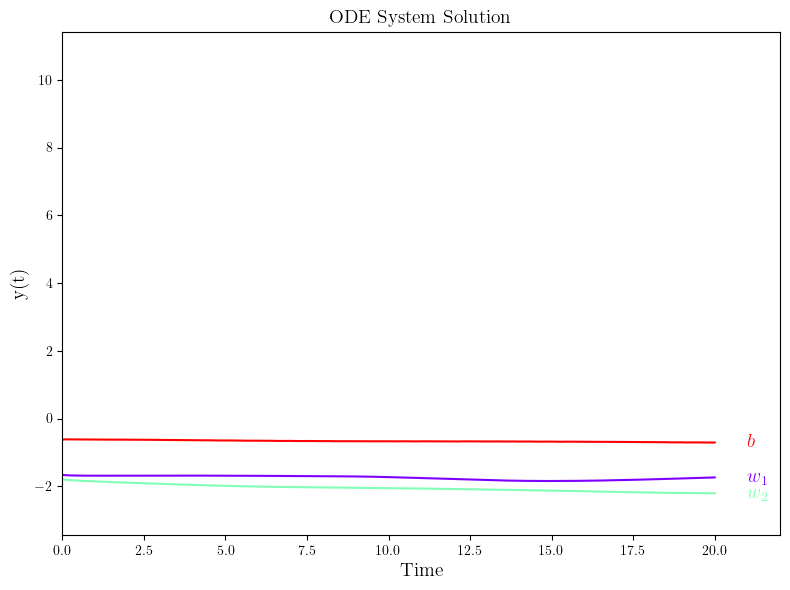

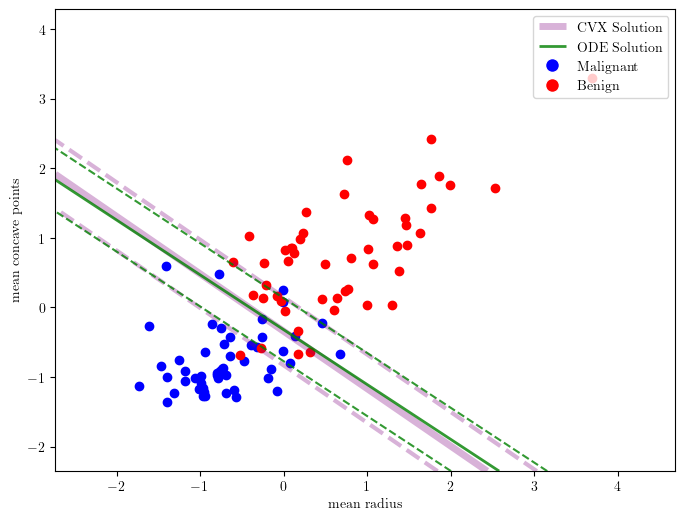

epsilon: inf time: 7760.367501735687 iterations: 10000


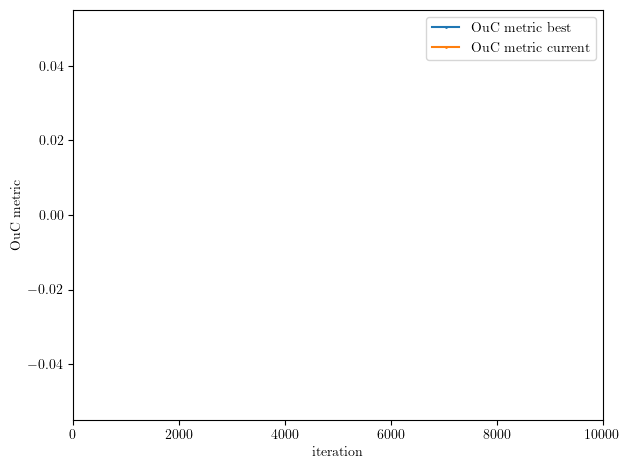

Last losses: [0.3031769394874573, 0.38184458017349243, 0.4399372935295105, 0.4809214174747467, 0.45362088084220886, 0.4175199866294861, 0.3418061137199402, 0.2586928606033325, 0.17238715291023254, 0.10212782025337219]


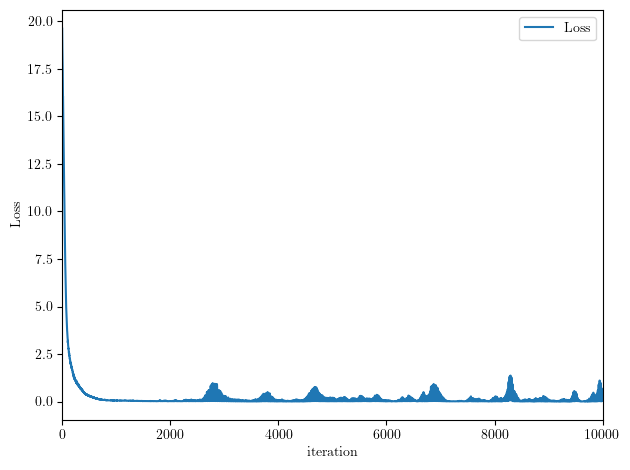

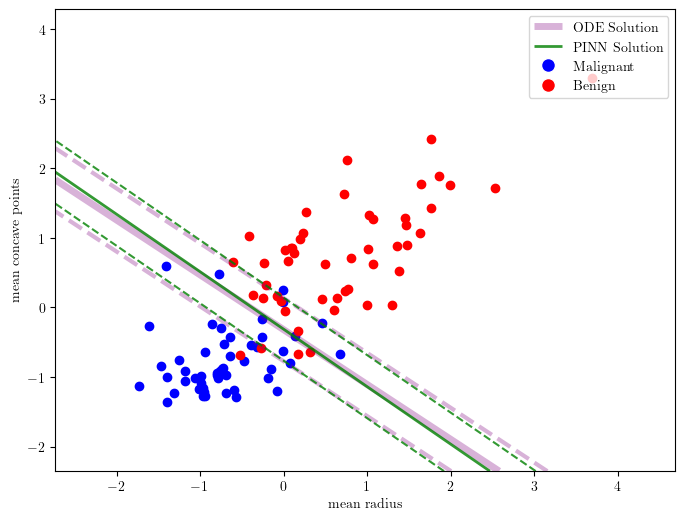

Variables: [-1.8225867  -2.2053335  -0.69099647 -0.0065344   0.0097571  -0.01444997
 -0.00967294  0.01495731  0.00618609  0.16885898 -0.00068941 -0.00871845
 -0.120084   -0.00586514 -0.02595903 -0.00560921  0.00879767  0.01574072
 -0.00309305  0.0023141  -0.00038064 -0.00199726  1.0240526  -0.00897317
 -0.00090447 -0.00135459  0.0217398  -0.00444171  0.0107845   0.07851081
 -0.00066613  1.3128561   0.01824421  0.01882052  0.00197774 -0.01481909
 -0.01160704 -0.00003647  0.0258664   0.02690556 -0.00198928  0.01798164
  0.00531169 -0.08678868  2.0231247   0.00279394  0.01603718  0.01066368
 -0.00099999 -0.00827805 -0.00821146  0.00911497  0.00060948  0.8540203
  1.7981184   2.2161546  -0.00207524 -0.014466   -0.00473726  0.4686709
 -0.00575453  0.12010874  0.02789794 -0.0095493   0.6121976  -0.02021541
  0.0121868  -0.00816863  1.4791266  -0.00147942  0.48061287  0.00745263
  0.01235085  2.1082032  -0.00320758  0.11853217 -0.17543977  0.03651074
 -0.00790846 -0.00444339  0.0061978   0.00

Time: 2.191655397415161
objective: 220.23361 lim: 0.1
objective: 220.23361
w:  [-1.57377208 -2.09412436] b:  -0.6618290747598657
hyperplane similarity: 0.0062738442551069085
Dual variables (alpha): [-1.57377208 -2.09412436 -0.66182907  0.0000004   0.00000034  0.00000047
  0.00000046 -0.00000043 -0.00000047  0.34091771 -0.00000036 -0.0000005
 -0.04178099  0.00000045  0.00000005  0.00000046  0.00000047 -0.00000042
  0.00000045  0.00000047  0.00000046 -0.00000052  0.99966501  0.00000047
 -0.00000045 -0.00000047  0.00000002  0.00000044 -0.00000044  0.00000032
  0.00000048  1.45050469 -0.00000011  0.00000169 -0.00000048  0.00000085
  0.00000046  0.0000004   0.05974041 -0.00000115  0.00000044  0.00000014
 -0.00000047 -0.0163298   1.91042371  0.00000052  0.00000013  0.00000029
  0.00000041  0.00000046  0.00000047 -0.00000041  0.00000047  0.91954224
  1.80560368  2.19092719 -0.00000047  0.00000047 -0.00000048  0.69449999
 -0.00000041  0.34988217 -0.03222499  0.00000036  0.55732499 -0.00000002


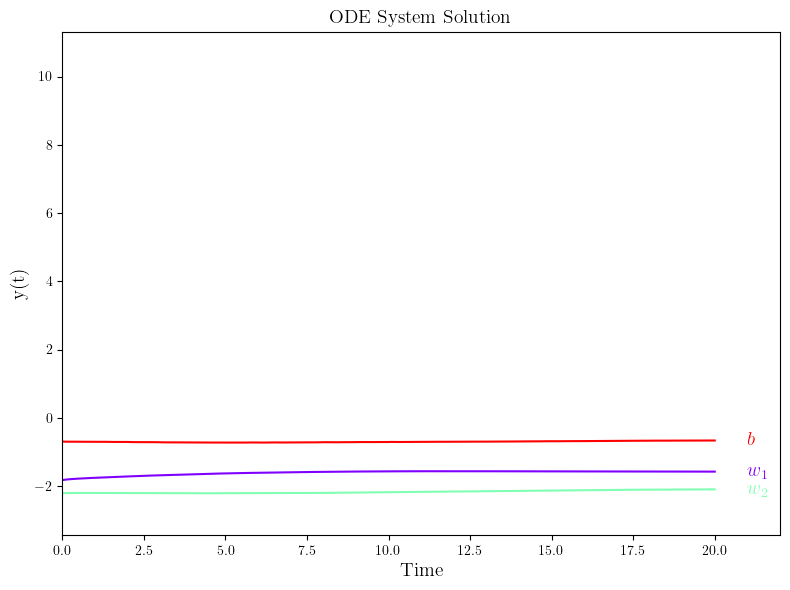

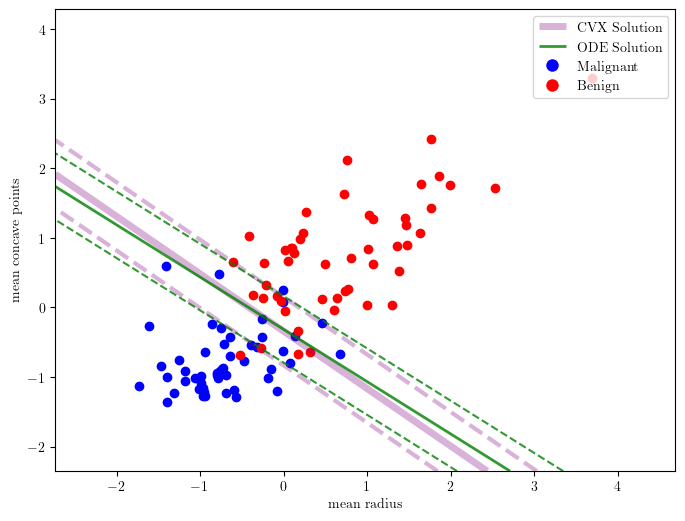

epsilon: inf time: 5255.771003961563 iterations: 7004


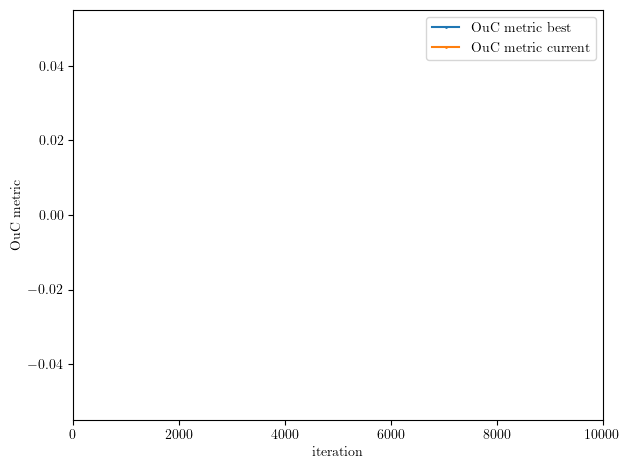

Last losses: [0.02261650376021862, 0.01943018287420273, 0.017169542610645294, 0.015020627528429031, 0.01119973137974739, 0.008740011602640152, 0.007360875606536865, 0.006739930249750614, 0.007156951352953911, 0.008053179830312729]


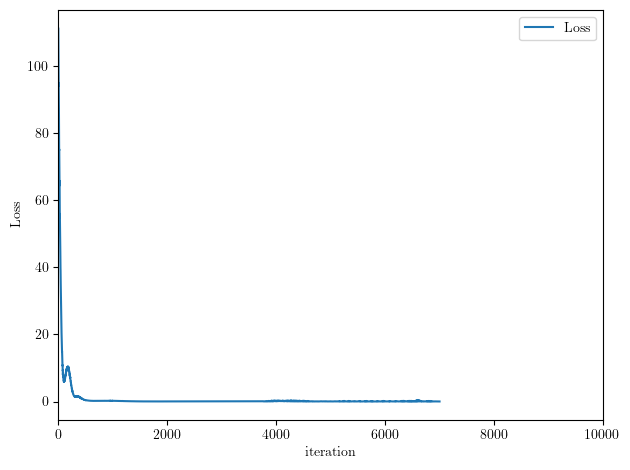

>>> NN Solution is accurate, last iteration


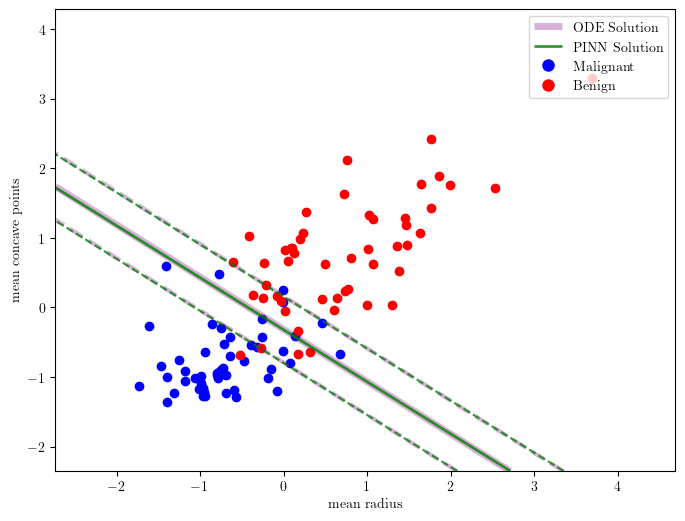

Variables: [-1.5683407  -2.0955539  -0.6724063  -0.00215476 -0.00869615  0.02033515
 -0.00584922  0.00133221  0.00095414  0.3519993  -0.00210251 -0.00632599
 -0.04121339 -0.009538   -0.00767666  0.0035855  -0.0001152   0.00261243
 -0.0027395   0.0019998   0.00367935  0.00045645  0.9985636  -0.00756583
  0.00794106 -0.00290405 -0.00489951  0.00036406 -0.00899183 -0.0133307
  0.01230409  1.473395   -0.00730521 -0.00980824 -0.00089674  0.00568202
  0.01224566 -0.00317766  0.0657307  -0.000135    0.00347188  0.00042523
 -0.0181266  -0.01774171  1.9095722   0.00194596  0.00098375  0.00096125
 -0.00090118  0.00847014 -0.00031128 -0.00012895  0.00283204  0.9278382
  1.8181856   2.2003422  -0.00340184  0.00907509  0.01292147  0.7269002
 -0.00166462  0.44812763 -0.047106    0.00437299  0.5405546  -0.01011649
 -0.01147371  0.00290609  1.4798462   0.02296983  0.43030378  0.01136469
  0.00702471  1.9950577  -0.0030444   0.19495007  0.02183318 -0.01215809
  0.00795988  0.00479044  0.00625072  0.008

In [14]:
ITERATIONS = 2000
LR = 0.01
ip = np.zeros(NY)
ip[:nw + nb] = 1.0

for i in range(5):
    print('>>>> ITERATION:', i+1)
    res, pinn_obj, lastIter = iteration(ip)
    wb_pinn = res[:nw+1]
    if lastIter:
        print('>>>> Results obtained, OuC: ', pinn_obj)
        break
    ip = res
    ITERATIONS = 10000
    LR = 0.0001